# Data Preprocessing

In [10]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LogisticRegression
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

from rpy2 import robjects as ro
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects import default_converter
from rpy2.robjects.conversion import localconverter
# Load Rforestry package
r('if (!requireNamespace("devtools", quietly = TRUE)) install.packages("devtools")')
r('library(devtools)')
r('devtools::load_all("../Rforestry")')
forestry = importr("Rforestry")

ℹ Loading Rforestry
! Adding files missing in collate:
  '/Users/evgeniikuriabov/PycharmProjects/JCGS_review/Rforestry/R/leafCoefficients.R'


R callback write-console: ## 
##  Rforestry (Version 0.10.1, Build Date: )
##  See https://github.com/forestry-labs for additional documentation.
##  Please cite software as:
##    Soren R. Kunzel, Theo F. Saarinen, Edward W. Liu, Jasjeet S. Sekhon. 2019.
##    ''Linear Aggregation in Tree-based Estimators.'' arXiv preprint 
##    arXiv:1906.06463. https://arxiv.org/abs/1906.06463 
##
  


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

def rmse(y_true,y_pred):
    return root_mean_squared_error(y_true,y_pred)

In [4]:
class _ForestryMixin(BaseEstimator):
    _ntree: int = 1

    def __init__(self):
        self.model_ = None

    def fit(self, X, y):
        with localconverter(default_converter + pandas2ri.converter):
            ro.globalenv["X"] = pd.DataFrame(X)
            ro.globalenv["y"] = pd.Series(y)
        ro.r(f"model <- forestry(x = X, y = y, ntree = {self._ntree})")
        self.model_ = ro.globalenv["model"]
        return self

    def _predict_r(self, newX):
        with localconverter(default_converter + pandas2ri.converter):
            ro.globalenv["X_new"] = pd.DataFrame(newX)
        preds = ro.r("predict(model, newdata = X_new, feature.new = X_new)")
        return np.asarray(preds, dtype=float)

class LRTClassifier(_ForestryMixin, ClassifierMixin):
    _ntree = 1
    def predict_proba(self, X):
        p = self._predict_r(X)
        return np.column_stack([1 - p, p])
    def predict(self, X):
        return (self._predict_r(X) > 0.5).astype(int)

class LRTRegressor(_ForestryMixin, RegressorMixin):
    _ntree = 1
    def predict(self, X):
        return self._predict_r(X)
    
class LRFClassifier:
    """Light wrapper around Rforestry with adjustable ntree."""
    def __init__(self, ntree=500):
        self._ntree = ntree
        self.model_ = None

    def fit(self, X, y):
        # push into R
        with localconverter(default_converter + pandas2ri.converter):
            ro.globalenv["X"] = pd.DataFrame(X)
            ro.globalenv["y"] = pd.Series(y)
        # call forestry()
        ro.r(f"model <- forestry(x = X, y = y, ntree = {self._ntree})")
        self.model_ = ro.globalenv["model"]
        return self

    def predict(self, X):
        # push new data
        with localconverter(default_converter + pandas2ri.converter):
            ro.globalenv["X_new"] = pd.DataFrame(X)
        preds = ro.r("predict(model, newdata = X_new, feature.new = X_new)")
        # threshold at 0.5
        return (np.asarray(preds, dtype=float) > 0.5).astype(int)
    
class LRFRegressor:
    """Light wrapper around Rforestry with adjustable ntree."""
    def __init__(self, ntree=500):
        self._ntree = ntree
        self.model_ = None

    def fit(self, X, y):
        # push into R
        with localconverter(default_converter + pandas2ri.converter):
            ro.globalenv["X"] = pd.DataFrame(X)
            ro.globalenv["y"] = pd.Series(y)
        # call forestry()
        ro.r(f"model <- forestry(x = X, y = y, ntree = {self._ntree})")
        self.model_ = ro.globalenv["model"]
        return self

    def predict(self, X):
        # push new data
        with localconverter(default_converter + pandas2ri.converter):
            ro.globalenv["X_new"] = pd.DataFrame(X)
        preds = ro.r("predict(model, newdata = X_new, feature.new = X_new)")
        return np.asarray(preds, dtype=float)

In [5]:
# read Bike Sharing data
path = './data/'
df = pd.read_csv(path + "hour.csv.gz", compression="gzip")

orig_predictor_headers = list(df)
outcome_header = "cnt"
used_headers = orig_predictor_headers
used_headers.remove("instant")
used_headers.remove("dteday")
used_headers.remove("casual")
used_headers.remove("registered")
df2 = df[used_headers]

def add_dummy(v, data):
    dummy_cols = v
    dummy = pd.get_dummies(df[dummy_cols], drop_first=True, dtype=float)
    dummy.columns = [dummy_cols+"_{}".format(i) for i in range(dummy.shape[1])]
    data = pd.concat([data, dummy], axis=1)
    data.drop([dummy_cols], axis=1, inplace=True)
    return data

USE_DUMMIES = True
if USE_DUMMIES:
    data = df2
    data = add_dummy('season',data)
    data = add_dummy('weathersit',data)
    
feature_names = list(data)
feature_names.remove('cnt')

y = data['cnt'].values
X = data[feature_names].values

print(X.shape, y.shape)
feature_names

(17379, 16) (17379,)


['yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'season_0',
 'season_1',
 'season_2',
 'weathersit_0',
 'weathersit_1',
 'weathersit_2']

In [6]:
feature_names_2 = [
'Year', 
'Month',
'Hour',
'Holiday', 
'Weekday', 
'Working day', 
'Temperature',                   
'Feeling temp',                     
'Humidity', 
'Wind speed',
'season_0',
'season_1',
'season_2',
'weathersit_0',
'weathersit_1',
'weathersit_2']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [8]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor

clf_1 = RandomForestRegressor()
clf_1.fit(X_train, y_train)
print('rmse train:', rmse(clf_1.predict(X_train), y_train))
print('rmse test:', rmse(clf_1.predict(X_test), y_test))

rmse train: 16.13746742238421
rmse test: 44.237832405877306


In [9]:
clf_2 = GradientBoostingRegressor()
clf_2.fit(X_train, y_train)
print('rmse train:', rmse(clf_2.predict(X_train), y_train))
print('rmse test:', rmse(clf_2.predict(X_test), y_test))

rmse train: 67.70735321983406
rmse test: 70.79570948464193


In [9]:
clf_3 = MLPRegressor(random_state=1, max_iter=1000)
clf_3.fit(X_train, y_train)
print('rmse train:', rmse(clf_3.predict(X_train), y_train))
print('rmse test:', rmse(clf_3.predict(X_test), y_test))

rmse train: 93.57666866398411
rmse test: 96.02432753385985


/Users/evgeniikuriabov/PycharmProjects/JCGS_review/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [10]:
clf_4 = LRFRegressor()

clf_4.fit(X_train, y_train)

forest_preds_train = clf_4.predict(X_train)
forest_preds = clf_4.predict(X_test)

print("Train:", rmse(y_train, forest_preds_train))
print("Test:", rmse(y_test, forest_preds))

Train: 23.46505537479559
Test: 54.41726548130009


In [11]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn import tree as tr

m1 = tr.DecisionTreeRegressor()
m1.fit(X_train, y_train)
m1_pred = m1.predict(X_train)
m1_pred_test = m1.predict(X_test)
print("Train DT:", rmse(m1_pred, y_train))
print("Test DT:", rmse(m1_pred_test, y_test), "depth", m1.get_depth())

m = LinearRegression()
m.fit(X_train, y_train)
m_pred = m.predict(X_train)
m_pred_test = m.predict(X_test)
print("Train:", rmse(m_pred, y_train))
print("Test:", rmse(m_pred_test, y_test))

Train DT: 0.5210452648487369
Test DT: 59.21024397808849 depth 30
Train: 140.02169796429774
Test: 143.19792214293304


In [12]:
m1.get_n_leaves()

13164

In [13]:
fr = LRTRegressor()

fr.fit(X_train, y_train)

forest_preds_train = fr.predict(X_train)
forest_preds = fr.predict(X_test)

print("Train:", rmse(y_train, forest_preds_train))
print("Test:", rmse(y_test, forest_preds))

Train: 53.828302869266146
Test: 88.62250789628972


# MLM Method

In [14]:
from generalized_mlm import MixtureLinearModel

/Users/evgeniikuriabov/PycharmProjects/JCGS_review/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [15]:
clfs = [clf_1, clf_2, clf_3, clf_4]

sorted_clf = []
for i in clfs:
    sorted_clf.append((i, rmse(i.predict(X_test), y_test)))
sorted_clf = sorted(sorted_clf, key=lambda x: x[1])

In [16]:
avg_variance = np.mean(np.var(X_train, axis=0))

In [17]:
MLM = MixtureLinearModel(sorted_clf, verbose=True)

In [18]:
MLM.compute_kmeans_CELL(X_train, K=100, random_seed=0)

/var/folders/q_/zp5hvt_11ggbtgc0n5grlrpc0000gn/T/ipykernel_64159/3400188333.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  MLM.compute_kmeans_CELL(X_train, K=100, random_seed=0)


16 (16,)
# of CELL:100 / min size:82 / avg size:139.0 / max size:206 / # of singleton CELL:0


In [19]:
MLM.fit_LocalModels(X_train, y_train, 
                    eps=0.01, num_noise_samp=100, 
                    classification=False, alpha=0, max_iter=10000, random_seed=0)

100%|██████████| 100/100 [00:00<00:00, 4645.52it/s]


In [20]:
pred_lmm_train = MLM.predict(X_train, covariance_type='full', covariance_tied=True, uniform_prior=False)
pred_lmm_test = MLM.predict(X_test, covariance_type='full', covariance_tied=True, uniform_prior=False)

100%|██████████| 100/100 [00:00<00:00, 596.71it/s]


In [21]:
print('MLM-CELL: Train RMSE:{:3.3f} / Test RMSE:{:3.3f}'.format(
            rmse(y_train, np.array(pred_lmm_train)),
            rmse(y_test, np.array(pred_lmm_test))))

MLM-CELL: Train RMSE:63.876 / Test RMSE:67.609


In [22]:
MLM.fit_MergedLocalModels(150, classification=False, alpha=0, max_iter=1000, random_seed=0)

100%|██████████| 100/100 [00:00<00:00, 248.88it/s]
/Users/evgeniikuriabov/PycharmProjects/JCGS_review/SynthTree/generalized_mlm.py:403: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  LocalModelsTree = linkage(self.dist_mat_avg, 'ward')
100%|██████████| 98/98 [00:00<00:00, 4417.62it/s]


In [23]:
pred_epic_train = MLM.predict(X_train,  merged=True, 
                covariance_type='full', covariance_tied=True, uniform_prior=False)
pred_epic_test = MLM.predict(X_test, merged=True, 
                covariance_type='full', covariance_tied=True, uniform_prior=False)

100%|██████████| 98/98 [00:00<00:00, 967.82it/s]


In [24]:
print('MLM-EPIC: Train RMSE:{:3.3f} / Test RMSE:{:3.3f}'.format(
            rmse(y_train, np.array(pred_epic_train)),
            rmse(y_test, np.array(pred_epic_test))))

MLM-EPIC: Train RMSE:63.970 / Test RMSE:67.520


In [25]:
MLM_results_5_run_test = []
MLM_results_5_run_train = []
for run in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)
    clf_1 = RandomForestRegressor()
    clf_1.fit(X_train, y_train)
    clf_2 = GradientBoostingRegressor()
    clf_2.fit(X_train, y_train)
    clf_3 = MLPRegressor(random_state=None, max_iter=1000)
    clf_3.fit(X_train, y_train)
    clfs = [clf_1, clf_2, clf_3]
#     clfs = [clf_3]
    sorted_clf = []
    for i in clfs:
        sorted_clf.append((i, rmse(i.predict(X_test), y_test)))
    sorted_clf = sorted(sorted_clf, key=lambda x: x[1])
    avg_variance = np.mean(np.var(X_train, axis=0))
    MLM = MixtureLinearModel(sorted_clf, verbose=True)
    MLM.compute_kmeans_CELL(X_train, K=100, random_seed=None)
    MLM.fit_LocalModels(X_train, y_train, 
                    eps=0.01, num_noise_samp=100, 
                    classification=False, alpha=0, max_iter=10000, random_seed=None)
    pred_lmm_train = MLM.predict(X_train, covariance_type='full', covariance_tied=True, uniform_prior=False)
    pred_lmm_test = MLM.predict(X_test, covariance_type='full', covariance_tied=True, uniform_prior=False)
    MLM.fit_MergedLocalModels(150, classification=False, alpha=0, max_iter=1000, random_seed=None)
    pred_epic_train = MLM.predict(X_train,  merged=True, 
                covariance_type='full', covariance_tied=True, uniform_prior=False)
    pred_epic_test = MLM.predict(X_test, merged=True, 
                covariance_type='full', covariance_tied=True, uniform_prior=False)
    
    MLM_results_5_run_train.append(rmse(y_train, np.array(pred_epic_train)))
    MLM_results_5_run_test.append(rmse(y_test, np.array(pred_epic_test)))

/var/folders/q_/zp5hvt_11ggbtgc0n5grlrpc0000gn/T/ipykernel_64159/2344323731.py:21: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  MLM.compute_kmeans_CELL(X_train, K=100, random_seed=None)


16 (16,)
# of CELL:100 / min size:83 / avg size:139.0 / max size:214 / # of singleton CELL:0


100%|██████████| 100/100 [00:00<00:00, 264.34it/s]
/Users/evgeniikuriabov/PycharmProjects/JCGS_review/SynthTree/generalized_mlm.py:403: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  LocalModelsTree = linkage(self.dist_mat_avg, 'ward')
100%|██████████| 98/98 [00:00<00:00, 594.61it/s]
/Users/evgeniikuriabov/PycharmProjects/JCGS_review/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/q_/zp5hvt_11ggbtgc0n5grlrpc0000gn/T/ipykernel_64159/2344323731.py:21: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  MLM.compute_kmeans_CELL(X_train, K=100, random_seed=None)


16 (16,)
# of CELL:100 / min size:92 / avg size:139.0 / max size:202 / # of singleton CELL:0


100%|██████████| 100/100 [00:00<00:00, 337.32it/s]
/Users/evgeniikuriabov/PycharmProjects/JCGS_review/SynthTree/generalized_mlm.py:403: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  LocalModelsTree = linkage(self.dist_mat_avg, 'ward')
100%|██████████| 98/98 [00:00<00:00, 740.75it/s]
/Users/evgeniikuriabov/PycharmProjects/JCGS_review/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/q_/zp5hvt_11ggbtgc0n5grlrpc0000gn/T/ipykernel_64159/2344323731.py:21: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  MLM.compute_kmeans_CELL(X_train, K=100, random_seed=None)


16 (16,)
# of CELL:100 / min size:80 / avg size:139.0 / max size:197 / # of singleton CELL:0


100%|██████████| 100/100 [00:00<00:00, 278.79it/s]
/Users/evgeniikuriabov/PycharmProjects/JCGS_review/SynthTree/generalized_mlm.py:403: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  LocalModelsTree = linkage(self.dist_mat_avg, 'ward')
100%|██████████| 98/98 [00:00<00:00, 666.44it/s]
/Users/evgeniikuriabov/PycharmProjects/JCGS_review/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/q_/zp5hvt_11ggbtgc0n5grlrpc0000gn/T/ipykernel_64159/2344323731.py:21: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  MLM.compute_kmeans_CELL(X_train, K=100, random_seed=None)


16 (16,)
# of CELL:100 / min size:71 / avg size:139.0 / max size:212 / # of singleton CELL:0


100%|██████████| 100/100 [00:00<00:00, 292.45it/s]
/Users/evgeniikuriabov/PycharmProjects/JCGS_review/SynthTree/generalized_mlm.py:403: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  LocalModelsTree = linkage(self.dist_mat_avg, 'ward')
100%|██████████| 98/98 [00:00<00:00, 618.66it/s]
/var/folders/q_/zp5hvt_11ggbtgc0n5grlrpc0000gn/T/ipykernel_64159/2344323731.py:21: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  MLM.compute_kmeans_CELL(X_train, K=100, random_seed=None)


16 (16,)
# of CELL:100 / min size:99 / avg size:139.0 / max size:216 / # of singleton CELL:0


100%|██████████| 100/100 [00:00<00:00, 225.45it/s]
/Users/evgeniikuriabov/PycharmProjects/JCGS_review/SynthTree/generalized_mlm.py:403: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  LocalModelsTree = linkage(self.dist_mat_avg, 'ward')
100%|██████████| 98/98 [00:00<00:00, 924.52it/s]


In [26]:
#Results
print("Train:", MLM_results_5_run_train, "\nTest:", MLM_results_5_run_test)
print('std test:', np.std(MLM_results_5_run_test))
print('Mean test:', np.mean(MLM_results_5_run_test))

Train: [63.74595222743136, 64.33946314277864, 63.11157943247537, 65.508779881434, 64.6599541579992] 
Test: [68.75469305376586, 66.68084234951567, 68.4935777976057, 72.01625225025664, 66.24964336572063]
std test: 2.0388121687962246
Mean test: 68.4390017633729


# SynthTree

### Selecting the best K

In [11]:
from sklearn.metrics import f1_score
import numpy as np

#Mutual prediction disparity functions

def regression_distance(model_s, model_t, data_s, data_t, m):
    n_s = len(data_s)
    n_t = len(data_t)

    sum_squared_diff = np.sum((model_s.predict(data_s) - model_t.predict(data_s))**2)
    sum_squared_diff += np.sum((model_s.predict(data_t) - model_t.predict(data_t))**2)

    distance = sum_squared_diff / (n_s + n_t + 2*m)
    return distance

def classification_distance(model_s, model_t, data_s, data_t, m):
    predictions_s = model_s.predict(data_s)
    predictions_t = model_t.predict(data_s)
    
    predictions_s = np.round(np.concatenate((predictions_s, model_s.predict(data_t))))
    predictions_t = np.round(np.concatenate((predictions_t, model_t.predict(data_t))))

    tp = np.sum((predictions_s == 1) & (predictions_t == 1))
    fp = np.sum((predictions_s == 1) & (predictions_t == 0))
    fn = np.sum((predictions_s == 0) & (predictions_t == 1))

    if tp == 0:
        distance = np.inf
    else:
        distance = (fp + fn) / (2 * tp)

    return distance


def dist_matrix(num_clusters, classification = False):
    distance_matrix = np.zeros((num_clusters, num_clusters))
    if classification == False:
        for s in range(num_clusters):
            for t in range(num_clusters):
                if s == t:
                    distance_matrix[s, t] = 0.0
                else:
                    distance_matrix[s, t] = regression_distance(models_all[num_clusters][s], models_all[num_clusters][t], augmented_data[num_clusters][s], augmented_data[num_clusters][t], m)

    if classification:
        for s in range(num_clusters):
            for t in range(num_clusters):
                if s == t:
                    distance_matrix[s, t] = 0.0
                else:
                    distance_matrix[s, t] = classification_distance(models_all[num_clusters][s], models_all[num_clusters][t], augmented_data[num_clusters][s], augmented_data[num_clusters][t], m)
    return distance_matrix

In [12]:
def run_grid_search_models(X_train, X_test, y_train, y_test):
    model_configs = {
        "RF": {
            "model": RandomForestRegressor(),
            "params": {"n_estimators": [100, 200], "max_depth": [None, 10]}
        },
        "GB": {
            "model": GradientBoostingRegressor(),
            "params": {"n_estimators": [100], "learning_rate": [0.1, 0.05], "max_depth": [3, 5]}
        },
        "MLP": {
            "model": MLPRegressor(solver='lbfgs', random_state=1, max_iter=1000),
            "params": {"hidden_layer_sizes": [(50,), (100,)], "alpha": [0.0001, 0.001]}
        }
    }

    best_models = {}

    # 1) RF, GB, MLP via GridSearchCV
    for name, cfg in model_configs.items():
        print(f"\nRunning GridSearchCV for {name}…")
        grid = GridSearchCV(cfg["model"], cfg["params"],
                            cv=3, scoring="roc_auc", n_jobs=-1)
        grid.fit(X_train, y_train)
        best = grid.best_estimator_
        best_models[name] = best

        y_tr = best.predict(X_train)
        y_te = best.predict(X_test)
        print(f"{name} Best Params: {grid.best_params_}")
        print(f"{name} RMSE Train: {rmse(y_train, y_tr):.4f}")
        print(f"{name} RMSE Test:  {rmse(y_test,  y_te):.4f}")

    # 2) LRF sweep over ntree = 100, 200, 500
    print("\nEvaluating LRFClassifier over ntree = [100, 500]…")
    best_auc = -np.inf
    best_nt  = None

    for nt in (100, 500):
        lrf = LRFRegressor(ntree=nt).fit(X_train, y_train)
        y_tr = lrf.predict(X_train)
        y_te = lrf.predict(X_test)

        train_auc = rmse(y_train, y_tr)
        test_auc  = rmse(y_test,  y_te)
        print(f" LRF ntree={nt} → Train RMSE={train_auc:.4f}, Test RMSE={test_auc:.4f}")

        if test_auc > best_auc:
            best_auc      = test_auc
            best_models["LRF"] = lrf
            best_nt       = nt

    print(f"LRF best ntree = {best_nt}\n")

    return best_models

In [13]:
m = 100 # Number of new points used for data augmentation (by co-supervision)
min_var = np.mean(np.var(X_train, axis=0))

def predict_mixture_of_models(X, local_models, kmeans):
    cluster_assignments = kmeans.predict(X)
    
    predictions = np.zeros_like(X[:, 0]) 

    for cluster, model in enumerate(local_models):
        cluster_indices = np.where(cluster_assignments == cluster)
        X_cluster = X[cluster_indices]
        predictions[cluster_indices] += model.predict(X_cluster)

    return predictions

def evaluate_overall_model(X, y, k, clf_models, classification=False):
    kmeans = KMeans(n_clusters=k, n_init=100)
    cluster_assignments = kmeans.fit_predict(X)
    
    roc_score = float('inf')

    local_models = []
    for cluster in range(k):
        cluster_indices = np.where(cluster_assignments == cluster)

        X_cluster = X[cluster_indices]
        y_cluster = y[cluster_indices]
        
        if len(np.unique(y_cluster)) < 2:
            clf = sorted_clf[-1][0]
#             print("cluster:", cluster)
        else:
            for i in clf_models:
#                 print("model in cluster:", i, "accuracy", roc_auc_score(y_cluster, i.predict(X_cluster)))
                if rmse(y_cluster, i.predict(X_cluster)) <= roc_score:
                    roc_score = rmse(y_cluster, i.predict(X_cluster))
                    clf = i
#                 print("best model:", clf)

        def chol_sample(mean, cov, size=1):
            cholesky_cov = np.linalg.cholesky(cov)
            random_samp = np.array([mean + cholesky_cov @ np.random.standard_normal(mean.size) for i in range(size)])
            return random_samp
        
#         cov = np.diag(np.zeros(X_cluster.shape[1]) + 0.001)
        
        sample_mean = np.mean(X_cluster, axis=0)
            
#         perturbed_samples = chol_sample(sample_mean, cov, m)

        variances = np.var(X_cluster, axis=0)
  
        perturbed_samples = np.random.normal(loc=sample_mean, scale=np.sqrt(variances), size=(m, X_cluster.shape[1]))
        
        perturbed_predictions = clf.predict(perturbed_samples)
        
        X_cluster = np.concatenate((X_cluster, perturbed_samples))
        y_cluster = np.concatenate((y_cluster, perturbed_predictions))
        augmented_data[k][cluster] = X_cluster
        augmented_y[k][cluster] = y_cluster
        clf_model[k][cluster] = clf

        if classification == True:
            if len(np.unique(y_cluster)) == 1:
                model = LogisticRegression(solver='saga')
                model.classes_ = np.unique(y_cluster)
                model.coef_ = np.zeros((1, X.shape[1]))
                model.intercept_ = 0.0
            else:
                model = LogisticRegression(solver='saga')
                model.fit(X_cluster, y_cluster)
        else:
            model = LinearRegression()
            model.fit(X_cluster, y_cluster)
        local_models.append(model)
        models_all[k][cluster] = model

    predictions = predict_mixture_of_models(X, local_models, kmeans)
    overall_score = rmse(y, predictions)
    
    return overall_score, augmented_data, augmented_y, models_all

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# Set the maximum possible value of k
max_k = 50

# Iterate over different values of k and record the performance
best_k = None
best_score = float('inf')
augmented_data = {}
augmented_y = {}
models_all = {}
clf_model = {}

best_models = run_grid_search_models(X_train, X_test, y_train, y_test)
clf_1 = best_models["RF"]
clf_2 = best_models["GB"]
clf_3 = best_models["MLP"]
clf_4 = best_models["LRF"]

clfs = [clf_1, clf_2, clf_3, clf_4]
# clfs = [clf_1]

sorted_clf = []
for i in clfs:
    sorted_clf.append((i, rmse(i.predict(X_train), y_train)))
sorted_clf = sorted(sorted_clf, key=lambda x: x[1])

for k in range(10, max_k + 1, 10):
    print("k:", k)
    augmented_data[k] = {}
    augmented_y[k] = {}
    models_all[k] = {}
    clf_model[k] ={}
    
    overall_score = evaluate_overall_model(X_train, y_train, k, clfs, classification=False)

    # Update best_k if a higher overall score is achieved
    if overall_score[0] < best_score:
        best_score = overall_score[0]
        best_k = k

# Final model using the best k
kmeans = KMeans(n_clusters=best_k, n_init=100)
cluster_assignments = kmeans.fit_predict(X_train)

local_models = []
for cluster in range(best_k):
    cluster_indices = np.where(cluster_assignments == cluster)
    X_cluster = X_train[cluster_indices]
    y_cluster = y_train[cluster_indices]

    model = LinearRegression()
    model.fit(X_cluster, y_cluster)
    local_models.append(model)

predictions = predict_mixture_of_models(X_train, local_models, kmeans)
print(f"Best k: {best_k}, Best RMSE score: {best_score}")
print("RMSE:", rmse(y_train, predictions))


Running GridSearchCV for RF…


/Users/evgeniikuriabov/PycharmProjects/JCGS_review/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/evgeniikuriabov/PycharmProjects/JCGS_review/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/evgeniikuriabov/PycharmProjects/JCGS_review/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/evgeniikuriabov/PycharmProjects/JCGS_review/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 379, in _score
    response_method = _check_response_method(estimator, self._response_method)
  File "/Users/evgeniikuriabov/PycharmProjects/JCGS_re

RF Best Params: {'max_depth': None, 'n_estimators': 100}
RF RMSE Train: 16.0901
RF RMSE Test:  44.1153

Running GridSearchCV for GB…


/Users/evgeniikuriabov/PycharmProjects/JCGS_review/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/evgeniikuriabov/PycharmProjects/JCGS_review/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/evgeniikuriabov/PycharmProjects/JCGS_review/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/evgeniikuriabov/PycharmProjects/JCGS_review/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 379, in _score
    response_method = _check_response_method(estimator, self._response_method)
  File "/Users/evgeniikuriabov/PycharmProjects/JCGS_re

GB Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
GB RMSE Train: 67.7074
GB RMSE Test:  70.8011

Running GridSearchCV for MLP…


/Users/evgeniikuriabov/PycharmProjects/JCGS_review/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/evgeniikuriabov/PycharmProjects/JCGS_review/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/evgeniikuriabov/PycharmProjects/JCGS_review/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/evgeniikuriabov/PycharmProjects/JC

MLP Best Params: {'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
MLP RMSE Train: 91.3991
MLP RMSE Test:  95.9555

Evaluating LRFClassifier over ntree = [100, 500]…
 LRF ntree=100 → Train RMSE=24.3424, Test RMSE=56.5069
 LRF ntree=500 → Train RMSE=23.2126, Test RMSE=55.5041
LRF best ntree = 100
k: 10
k: 20
k: 30
k: 40
k: 50
Best k: 50, Best RMSE score: 76.16507469945431
RMSE: 73.9745244919734


### Growing the Tree

In [14]:
best_k = 50
kmeans = KMeans(n_clusters=best_k, n_init=100)
cluster_assignments = kmeans.fit_predict(X_train)

In [15]:
# Function to predict using the mixture of linear models
def predict_mixture_of_models(X, local_models, kmeans):
    cluster_assignments = kmeans.predict(X)
    
    predictions = np.zeros_like(X[:, 0])  # Initialize predictions

    for cluster, model in enumerate(local_models):
        cluster_indices = np.where(cluster_assignments == cluster)
        X_cluster = X[cluster_indices]
        predictions[cluster_indices] += model.predict(X_cluster)

    return predictions

# Function to evaluate overall model performance for a given k
def evaluate_overall_model(X, y, k, clf_models, classification=False):
    rmse_score = float('inf')

    local_models = []
    for cluster in range(k):
        cluster_indices = np.where(cluster_assignments == cluster)
        X_cluster = X_train[cluster_indices]
        y_cluster = y_train[cluster_indices]
        
        if len(np.unique(y_cluster)) < 2:
            clf = sorted_clf[0][0]
#             print("cluster:", cluster)
        else:
            for i in clf_models:
                if rmse(y_cluster, i.predict(X_cluster)) <= rmse_score:
                    rmse_score = rmse(y_cluster, i.predict(X_cluster))
                    clf = i
                    
        sample_mean = np.mean(X_cluster, axis=0)
        
        variances = np.var(X_cluster, axis=0)
  
        perturbed_samples = np.random.normal(loc=sample_mean, scale=np.sqrt(variances), size=(m, X_cluster.shape[1]))
        
        perturbed_predictions = clf.predict(perturbed_samples)
        
        X_cluster = np.concatenate((X_cluster, perturbed_samples))
        y_cluster = np.concatenate((y_cluster, perturbed_predictions))
        augmented_data[k][cluster] = X_cluster
        augmented_y[k][cluster] = y_cluster
        clf_model[k][cluster] = clf

        if classification == True:
            if len(np.unique(y_cluster)) == 1:
                model = LogisticRegression(solver='saga')
                model.classes_ = np.unique(y_cluster)
                model.coef_ = np.zeros((1, X_train.shape[1]))
                model.intercept_ = 0.0
            else:
                model = LogisticRegression(solver='saga')
                model.fit(X_cluster, y_cluster)
        else:
            model = LinearRegression()
            model.fit(X_cluster, y_cluster)
        local_models.append(model)
        models_all[k][cluster] = model

    predictions = predict_mixture_of_models(X_train, local_models, kmeans)
    overall_score = rmse(y_train, predictions)
    
    return overall_score, augmented_data, augmented_y, models_all

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)


RMSE_test = []
RMSE_train = []
RMSE_beom_train = []
RMSE_beom_test = []
Best_depth = []

results = []
m = 100

clfs = [clf_1, clf_2, clf_3, clf_4]
# clfs = [clf_1]

for test in range(1):
    # Set the maximum possible value of k
    max_k = 50

    # Iterate over different values of k and record the performance
    best_score = float('inf')  # Initialize with a very low value
    augmented_data = {}
    augmented_y = {}
    models_all = {}
    clf_model = {}

    sorted_clf = []
    for i in clfs:
        sorted_clf.append((i, rmse(i.predict(X_train), y_train)))
    sorted_clf = sorted(sorted_clf, key=lambda x: x[1])

    for k in range(50, max_k + 1):
        print("k:", k)
        augmented_data[k] = {}
        augmented_y[k] = {}
        models_all[k] = {}
        clf_model[k] ={}

        overall_score = evaluate_overall_model(X_train, y_train, k, clfs, classification=False)

        # Update best_k if a higher overall score is achieved
        if overall_score[0] <= best_score:
            best_score = overall_score[0]
            best_k = k

    local_models = []
    for cluster in range(best_k):
        cluster_indices = np.where(cluster_assignments == cluster)
        X_cluster = X_train[cluster_indices]
        y_cluster = y_train[cluster_indices]

        model = LinearRegression()
        model.fit(X_cluster, y_cluster)
        local_models.append(model)

    predictions = predict_mixture_of_models(X_train, local_models, kmeans)

    import statistics

    dist = pd.DataFrame(dist_matrix(best_k, classification=False))

    CELL_centers = []
    CELL_variances = []
    for i in augmented_data[best_k]:
        CELL_variances.append(np.sqrt(np.var(augmented_data[best_k][i], axis=0)))
        CELL_centers.append(np.mean(augmented_data[best_k][i], axis=0))
    cells_df = pd.DataFrame(CELL_centers)

    y_local = []
    for i in range(len(CELL_centers)):
        y_local.append(statistics.mode(augmented_y[best_k][i]))


    import DECISION_TREE_CLASSIFIER as dtc

    for k in range(1, 2):
        rmse_curr = float('inf')
        rmse_curr_train = float('inf')
        best_depth = float('inf')

        tree = dtc.DistanceDecisionTree(max_depth=5, classification=False)

        tree.fit(np.array(cells_df), np.array(dist))

        data_transformed = [augmented_data[best_k][key] for key in range(len(augmented_data[best_k]))]
        data_transformed_y = [augmented_y[best_k][key] for key in range(len(augmented_y[best_k]))]
            
        X_transformed = np.array([item for sublist in [arr.tolist() for arr in data_transformed] for item in sublist])
        y_transformed = np.array([item for sublist in [arr.tolist() for arr in data_transformed_y] for item in sublist])
  
        print("Max Depth", tree.final_depth)

        cv_scores = {}
        test_score = {}
        train_score = {}
        best_tree = None
        best_cv = float('inf')  # we minimize RMSE
        
        for i in range(1, tree.final_depth + 1):
            
            fold_scores = []
            fold_test = []
            fold_train = []
            
            for train_idx, val_idx in kf.split(X_transformed):

                X_train_fold, X_val = X_transformed[train_idx], X_transformed[val_idx]
                y_train_fold, y_val = y_transformed[train_idx], y_transformed[val_idx]
            
                tree = dtc.DistanceDecisionTree(max_depth=i, classification=False)

                tree.fit(np.array(cells_df), np.array(dist))

                tree.fit_leaf_logistic_models(X_train_fold, y_train_fold)

                Y_pred_train = tree.predict(X_train_fold, y_train_fold)
                Y_pred_train = [a[0] if type(a[0])==np.float64 else a[0][0] for a in Y_pred_train]
                Y_pred = tree.predict(X_val, y_val)
                Y_pred = [a[0] if type(a[0])==np.float64 else a[0][0] for a in Y_pred]
                Y_pred_test = tree.predict(X_test, y_test)
                Y_pred_test = [a[0] if type(a[0])==np.float64 else a[0][0] for a in Y_pred_test]

                fold_accuracy = rmse(y_val, Y_pred)
                
                fold_scores.append(fold_accuracy)
                fold_train.append(rmse(y_train, tree.predict(X_train, y_train)))
                fold_test.append(rmse(y_test, Y_pred_test))

            print(f"Current Depth: {i}")
            cv_scores[i] = np.mean(fold_scores)
            test_score[i] = np.mean(fold_test)
            train_score[i] = np.mean(fold_train)
            
            if cv_scores[i] < best_cv:
                best_cv = cv_scores[i]
                best_tree = tree.copy()
                
    best_depth = min(cv_scores, key=lambda k: cv_scores[k])
    print("Best Depth:", best_depth, "Train:", train_score[best_depth], "Test:", 
          test_score[best_depth], "Val:", cv_scores[best_depth])
    print("S_interp:", best_tree.interp_info()[1])

k: 50
Max Depth 5
Current Depth: 1
Current:  1 127.07074398495584 <DECISION_TREE_CLASSIFIER.DistanceDecisionTree object at 0x33f37c790>
Current Depth: 2
Current:  2 113.70044264899798 <DECISION_TREE_CLASSIFIER.DistanceDecisionTree object at 0x365151430>
Current Depth: 3
Current:  3 90.83204540323197 <DECISION_TREE_CLASSIFIER.DistanceDecisionTree object at 0x33c7d6520>
Current Depth: 4
Current:  4 86.77383590800567 <DECISION_TREE_CLASSIFIER.DistanceDecisionTree object at 0x1775e7640>
Current Depth: 5
Current:  5 83.22937525260383 <DECISION_TREE_CLASSIFIER.DistanceDecisionTree object at 0x33c713970>
Best Depth: 5 Train: 77.9089888841465 Test: 81.97259932998894 Val: 83.22937525260383
S_interp: 10.23044142714395


In [19]:
best_tree.print_tree()

Feature 2 <= 12.547955434526937
Left:
  Feature 2 <= 7.419328938138124
  Left:
    Feature 2 <= 4.3551647758185075
    Left:
      Feature 2 <= 1.5181345874305257
      Left:
        Feature 9 <= 0.16143077575018022
        Left:
          Leaf: Accuracy Test= 24.0302
          Model: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x33f007730>
        Right:
          Leaf: Accuracy Test= 22.4591
          Model: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x33f007940>
      Right:
        Feature 0 <= 0.49705504742308354
        Left:
          Leaf: Accuracy Test= 10.9890
          Model: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x33f007fa0>
        Right:
          Leaf: Accuracy Test= 15.3574
          Model: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1775cdf10>
    Right:
      Feature 0 <= 0.4661494004671593
      Left:
        Leaf: Accuracy Test= 69.5787
        Mo

In [20]:
def collect_models_from_tree(node, models_list, leaves_sizes):
    if 'leaf' in node:
        models_list.append(node['model'])
        leaves_sizes.append(len(node['data_indices']))
    else:
        if 'left' in node:
            collect_models_from_tree(node['left'], models_list, leaves_sizes)
        if 'right' in node:
            collect_models_from_tree(node['right'], models_list, leaves_sizes)

In [21]:
MODELS = []
leaves_sizes = []
collect_models_from_tree(tree.tree, MODELS, leaves_sizes)

In [22]:
MODELS = [value for value in MODELS if value is not None]

In [23]:
final_df = pd.DataFrame()
final_df['size'] = leaves_sizes
final_df['model'] = MODELS

In [24]:
final_df = final_df.sort_values('size', ascending=False)

In [25]:
models_top = np.array(final_df.iloc[:5, 1])

In [26]:
def plot_ci(MODELS, feature_id, epic_id=None, feature_names=feature_names_2, intercept=True, sort=True, log_trans=True, ax=None, yticklabels=True, title=True):
    if ax == None:
        f, ax = plt.subplots(1,1,figsize=(3,7),dpi=600)
    
    param = np.array([MODELS[i].params for i in range(len(MODELS))])
    cilb = np.transpose([MODELS[i].conf_int() for i in range(len(MODELS))])[0]
    ciub = np.transpose([MODELS[i].conf_int() for i in range(len(MODELS))])[1]

    if epic_id == None:
        epic_id = range(param.shape[0])

    def log(x): return np.sign(x)*np.log(np.abs(x)+1)
    if log_trans:
        param = log(param)
        cilb = log(cilb)
        ciub = log(ciub)

    param = param[epic_id,:]
    cilb = cilb[:,epic_id]
    ciub = ciub[:,epic_id]

    data_dict = {}
    data_dict['category'] = ['ELC'+str(i+1) for i in epic_id]
    data_dict['coef'] = param[:,feature_id]
    data_dict['lower'] = cilb[feature_id,:]
    data_dict['upper'] = ciub[feature_id,:]
    dataset = pd.DataFrame(data_dict)
    
    defcol = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    for coef,lower,upper,y in zip(dataset['coef'],dataset['lower'],dataset['upper'],range(len(dataset))):
        ax.plot((lower,upper),(y,y),'-',color='#74a9cf', linewidth=3, alpha=0.9)
        ax.scatter(coef,y,color='black')
    ax.set_yticks(range(len(dataset)))
    ax.set_yticklabels(list(dataset['category']))
    ax.axvline(x=0,color='black',linewidth=1)
    if title:
        ax.set_title(feature_names[feature_id])

In [27]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_mosaic(MODELS, epic_id=None, feature_names=feature_names_2, intercept=True, sort=True, log_trans=True, ax=None):
    if ax == None:
        f, ax = plt.subplots(figsize=(7,3),dpi=300)
    
    cmap=plt.get_cmap('RdBu_r')
    param = np.array([MODELS[i].params for i in range(len(MODELS))])

    if epic_id == None:
        epic_id = range(param.shape[0])

    if log_trans:
        param = np.sign(param)*np.log(np.abs(param)+1)

    param = param[epic_id,:]

    if intercept:
        feature_names = np.concatenate([['intercept'],feature_names])

    vmax = np.max(np.abs(param))
    im = ax.imshow(param, cmap=cmap, vmin=-vmax, vmax=vmax)

    plt.xticks(ticks=range(0,len(feature_names)))
    ax.set_xticklabels(feature_names, rotation = 90)
    plt.yticks(ticks=range(0,len(epic_id)), labels = [i+1 for i in epic_id])
    plt.ylabel('ELC')
    plt.xlabel('Variable')


    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

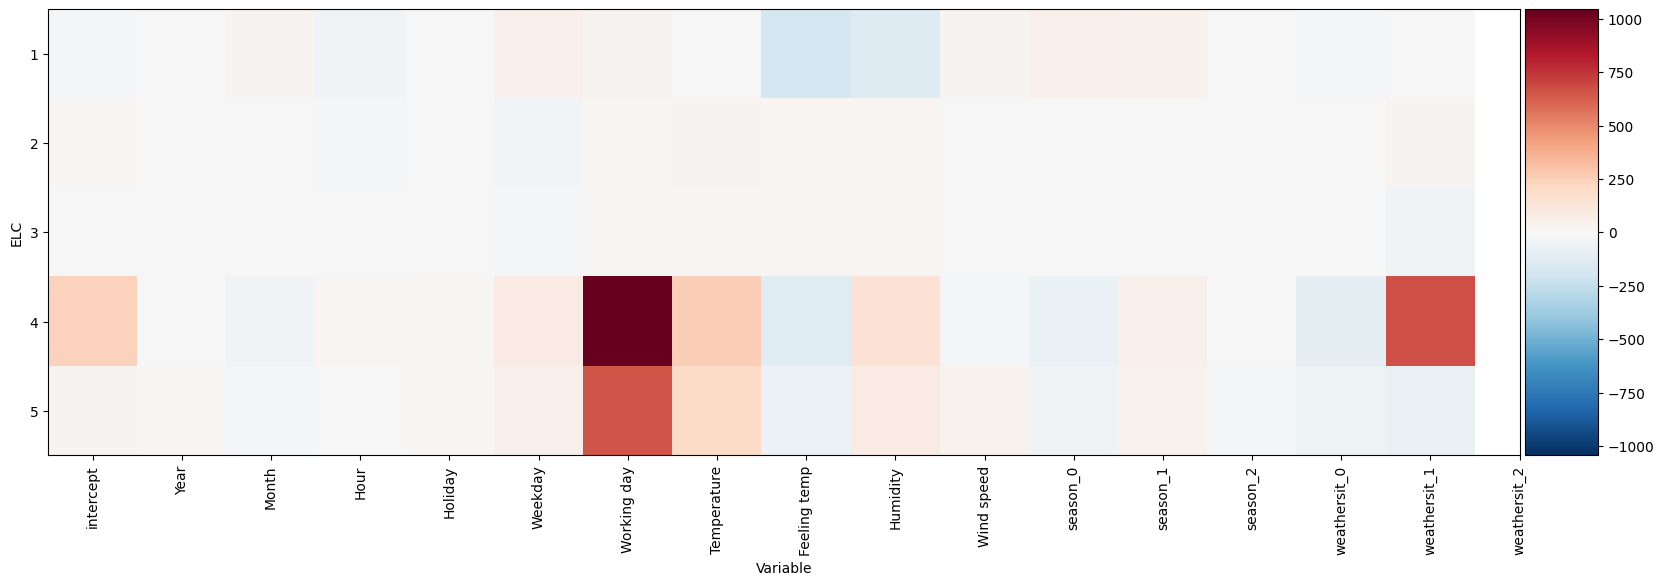

In [28]:
from matplotlib import pyplot as plt
import importlib

fig, ax = plt.subplots(figsize=(20, 10))
plot_mosaic(models_top, epic_id=range(5), log_trans=False, ax=ax)
# plt.savefig('Bike_Sharing_heatmap_2.pdf')

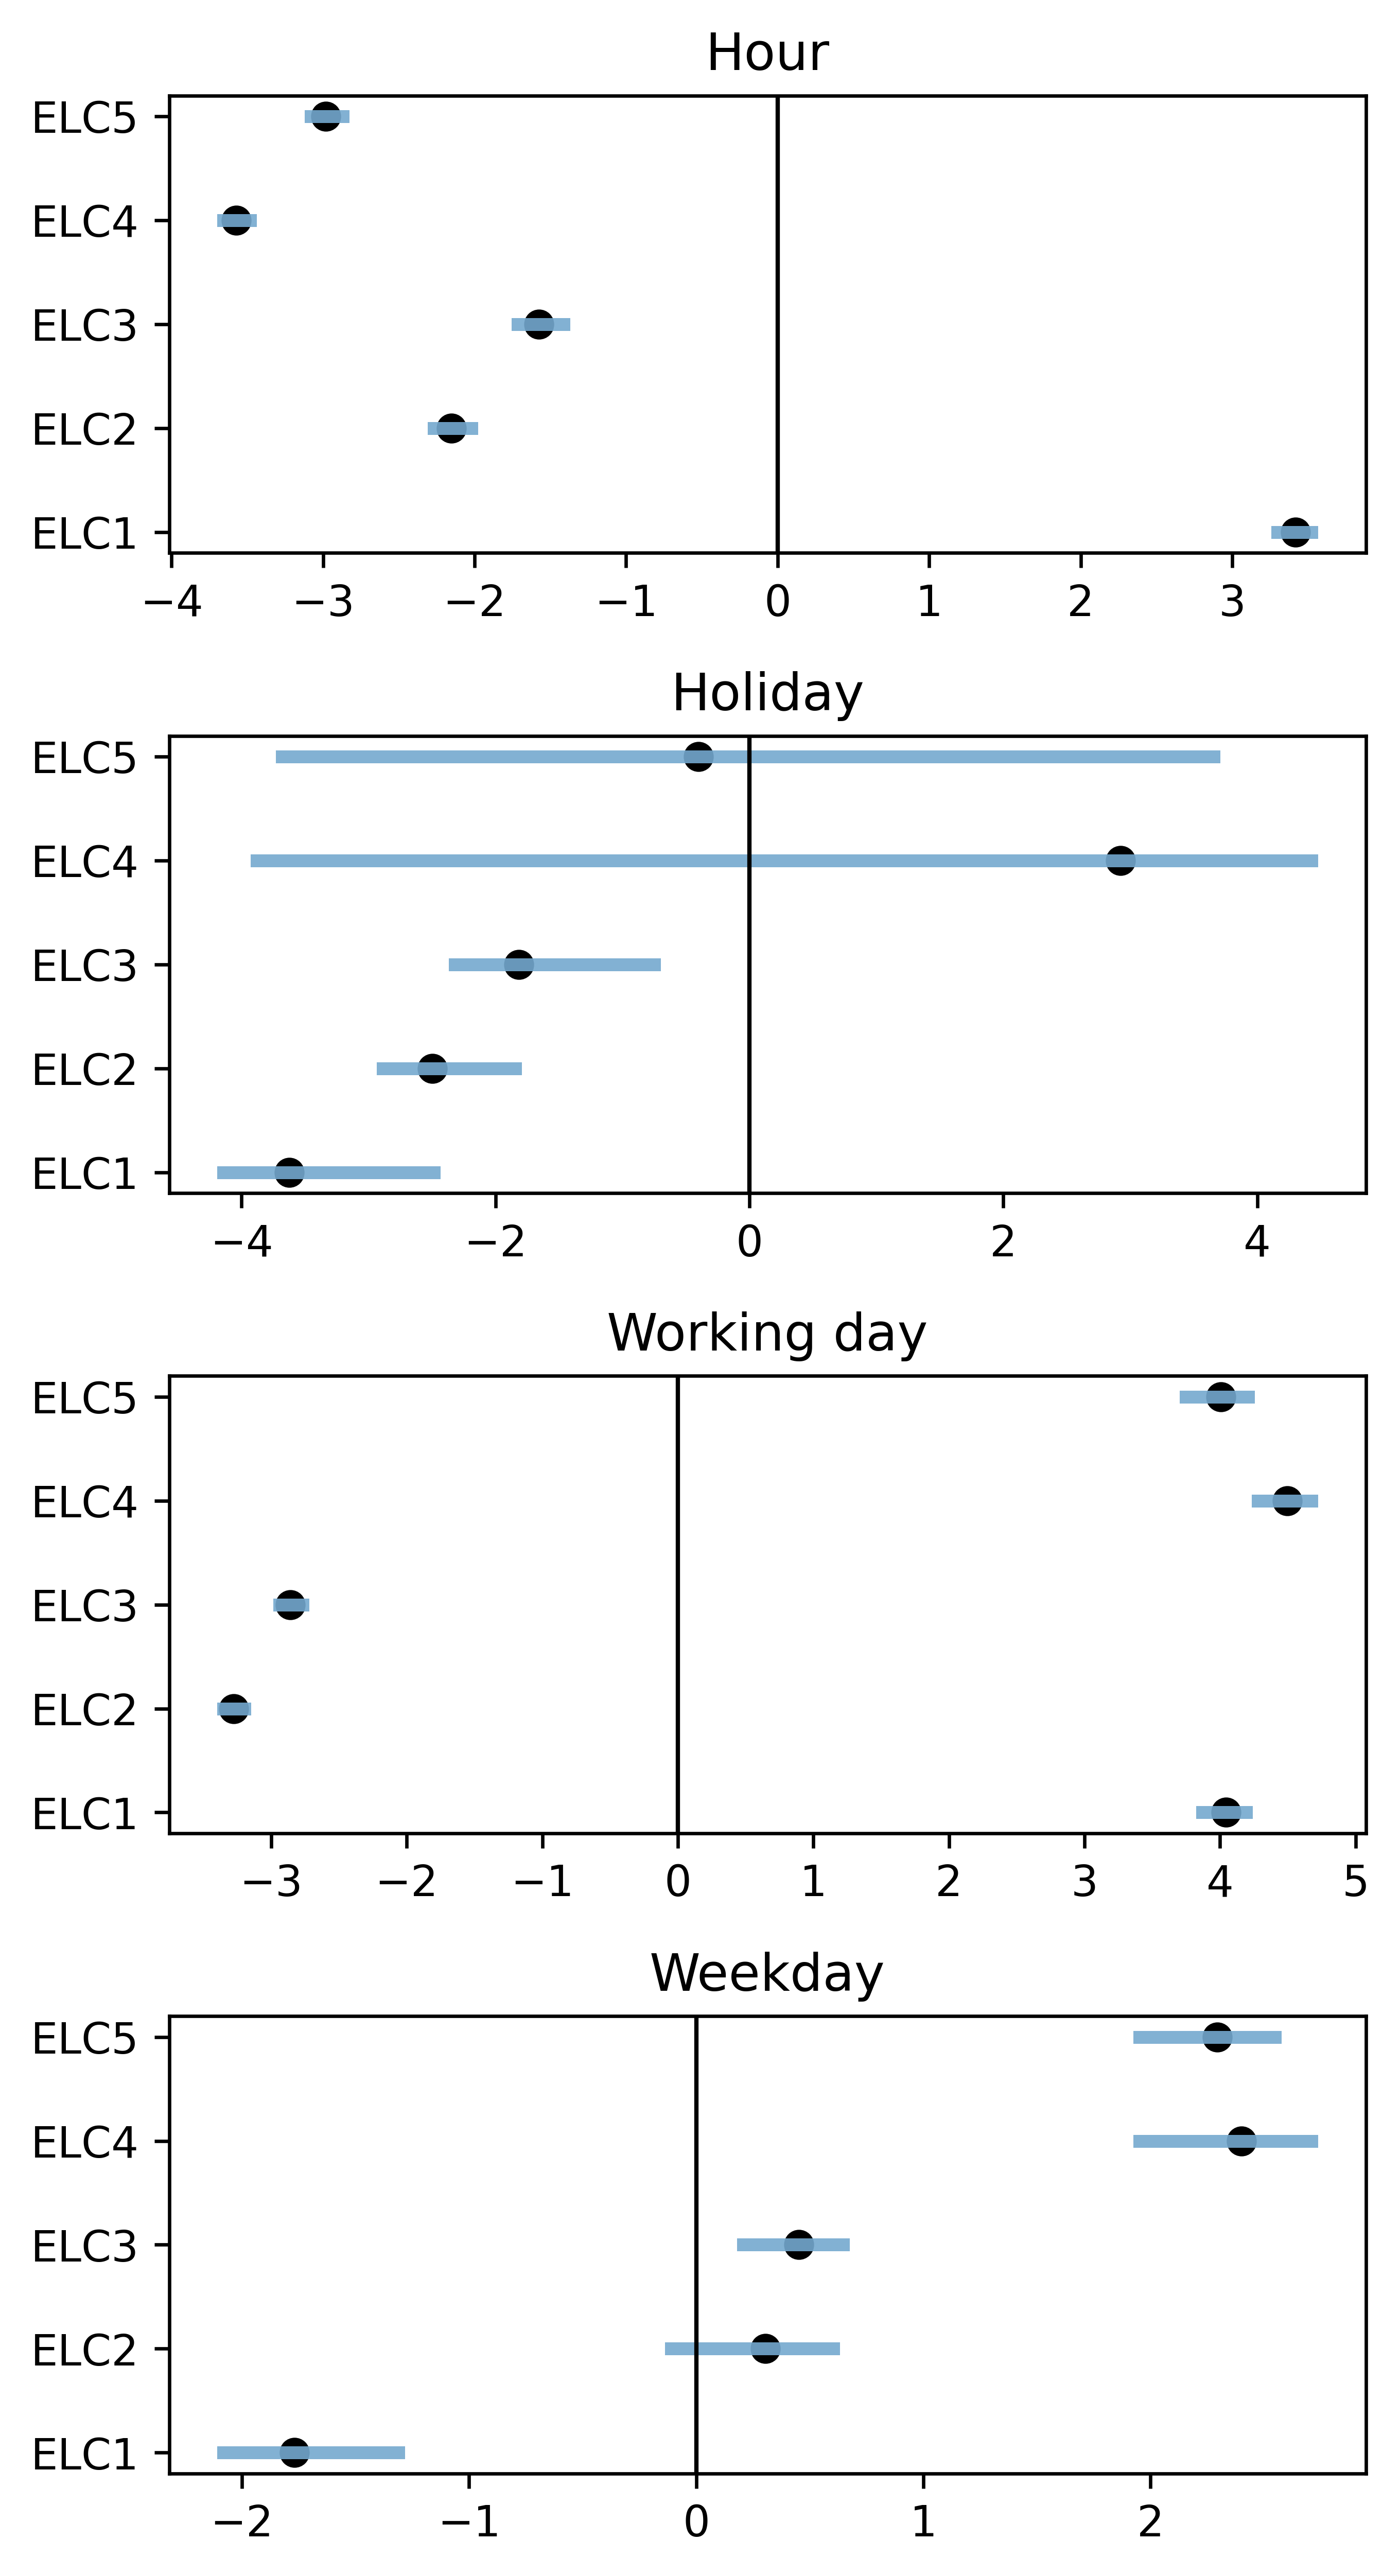

In [29]:
f, axs = plt.subplots(4,1,figsize=(5,10),dpi=600)
plt.subplots_adjust(hspace=0.4)
for i in range(4):
    j = (2,3,5,4)[i]
    ax = plt.subplot(4,1,i+1)
    plot_ci(models_top,j,epic_id=range(5),ax=ax,title=True)
    
# plt.subplots_adjust(hspace=0.5)